# Describing measures of similarity and diversity

We want to illustrate similarity and diversity measures with two toy examples.

We assume that we are considering the incremental profile of a single user.

Each item (they interact with) has an embedding. At minimal it can be a one-hot category:

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

user_categories = ["Book", "Cinema", "Book", "Opera"]
one_hot_encoder = CountVectorizer(analyzer='word')
category_embeddings = one_hot_encoder.fit_transform(user_categories).toarray()  # One-hot encoding
print('Vocabulary', one_hot_encoder.vocabulary_)
category_embeddings

Vocabulary {'book': 0, 'cinema': 1, 'opera': 2}


array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [2]:
rbf_kernel

<function sklearn.metrics.pairwise.rbf_kernel(X, Y=None, gamma=None)>

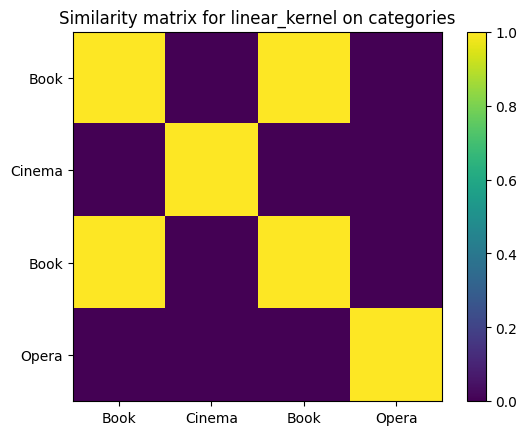

In [3]:
def display_kernel(embeddings, names, category, kernel=linear_kernel):
    sim = kernel(embeddings)

    fig, ax = plt.subplots()
    plt.imshow(sim)
    plt.title(f'Similarity matrix for {kernel.__name__} on {category}')
    plt.colorbar()
    extra_args = {'rotation': 20, 'ha': 'right'} if max(map(len, names)) > 10 else {}
    ax.set_xticks(range(len(names)), names, **extra_args)
    ax.set_yticks(range(len(names)), names)

display_kernel(category_embeddings, user_categories, 'categories')

Otherwise items can have a richer embedding based on bigrams on title, or other content (metadata, word2vec, music features, etc.).  
scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) has many possible parameters.

In [4]:
user_titles = [
    'One Piece T. 11', 'One Piece T. 12', 'Huis Clos de Sartre',
    'One Piece T. 14', 'One Piece: Film', 'One Piece OST'
]
bigram_encoder = CountVectorizer(analyzer='char', ngram_range=(2, 2))
title_embeddings = bigram_encoder.fit_transform(user_titles).toarray()
print(bigram_encoder.vocabulary_)
title_embeddings

{'on': 28, 'ne': 27, 'e ': 17, ' p': 5, 'pi': 30, 'ie': 22, 'ec': 19, 'ce': 14, ' t': 7, 't.': 36, '. ': 8, ' 1': 0, '11': 9, '12': 10, 'hu': 21, 'ui': 38, 'is': 24, 's ': 33, ' c': 1, 'cl': 15, 'lo': 26, 'os': 29, ' d': 2, 'de': 16, ' s': 6, 'sa': 34, 'ar': 13, 'rt': 32, 'tr': 37, 're': 31, '14': 11, 'e:': 18, ': ': 12, ' f': 3, 'fi': 20, 'il': 23, 'lm': 25, ' o': 4, 'st': 35}


array([[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]])

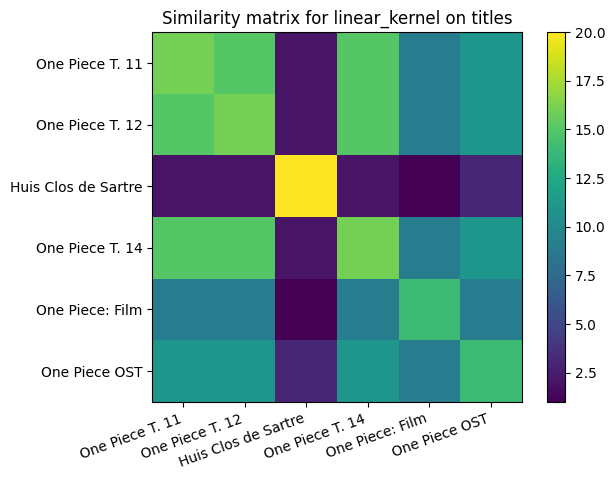

In [5]:
display_kernel(title_embeddings, user_titles, 'titles')

## Ridge leverage scores

This description comes from Definition 1 p. 4:

> Musco, Cameron, and Christopher Musco. "Recursive sampling for the nystrom method." Advances in neural information processing systems 30 (2017). https://proceedings.neurips.cc/paper/2017/file/a03fa30821986dff10fc66647c84c9c3-Paper.pdf

For each kernel matrix $\mathbf{K}$ we define the ridge leverage score of data point $\mathbf{x}_i$ with respect to $\mathbf{K}$ as:

$$\ell_i^\lambda(\mathbf{K}) = \left(\mathbf{K} (\mathbf{K} + \lambda \mathbf{I})^{-1}\right)_{i, i}$$

where $\lambda > 0$ is the regularization hyper-parameter (ridge).

> It is not hard to check that the ridge scores can be defined alternatively as: $$\ell_i^\lambda(\mathbf{K}) =  \min_{\mathbf{y} \in \mathbb{R}^n} \frac1\lambda ||\mathbf{b}^T_i - \mathbf{y}^T \mathbf{B}||_2^2 + ||\mathbf{y}||^2_2$$
This formulation provides better insight into the meaning of these scores. Since $\mathbf{B} \mathbf{B}^T = \mathbf{K}$, any
kernel learning algorithm effectively performs linear learning with $\mathbf{B}$’s rows as data points. So the
ridge scores should reflect the relative importance or uniqueness of these rows. From [this equation] it’s clear
that $\ell_i^\lambda \leq 1$ since we can set $\mathbf{y}$ to the $i$th standard basis vector. A row $\mathbf{b}^T_i$ will have ridge score $\ll 1$
(i.e. is less important) when it’s possible to find a more “spread out” y that uses other rows in $\mathbf{B}$
to approximately reconstruct $\mathbf{b}^T_i$ – in other words when the row is less unique.

Let's see a couple of examples.

array([0.49751244, 0.99009901, 0.49751244, 0.99009901])

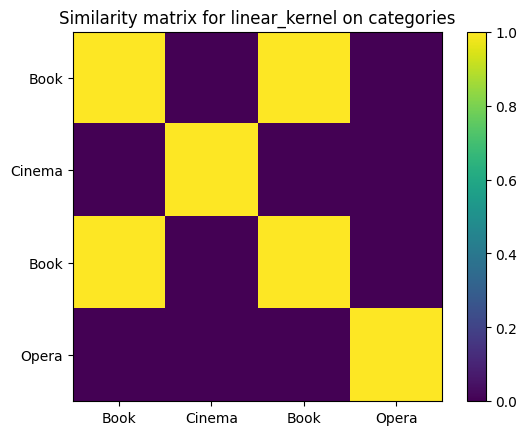

In [6]:
LAMBDA = 0.01

def compute_leverage_scores(K):
    N = len(K)
    return np.diagonal(K @ np.linalg.inv(K + LAMBDA * np.identity(N)))

display_kernel(category_embeddings, user_categories, 'categories')

compute_leverage_scores(linear_kernel(category_embeddings))

We can see that both `Book` have leverage score 0.49 because there is another `Book` in the profile.

`Cinema` and `Opera` are unique and have leverage score 0.99.

These leverage scores are considered for sampling a representative subset of rows in techniques like Nyström (that is, covariance matrix approximation). It is usually useful for cutting the $O(N^3)$ complexity of kernels, however computing the exact ridge leverage scores requires inverting a $N \times N$ matrix which itself has complexity $O(N^3)\ldots$

Another quantity of interest is called the **effective dimension** or **degrees of freedom** for a ridge regression problem on $\mathbf{K}$ with regularization $\lambda$:

$$d_{\textrm{eff}}^\lambda = \sum_i^n \ell_i^\lambda(\mathbf{K}) = tr\left(\mathbf{K}\left(\mathbf{K} + \lambda \mathbf{I}\right)^{-1}\right)$$

In [7]:
random_embeddings = np.random.random(size=(100, 4))

sum(compute_leverage_scores(linear_kernel(random_embeddings)))

3.996298987285324

In [8]:
sum(compute_leverage_scores(rbf_kernel(random_embeddings)))

17.14511638981776

A first observation (linear algebra textbook 🤓) is that the effective dimension can never be higher than the rank of the matrix. So in the case of the linear kernel, it will never be higher than the embedding size. If we use the RBF kernel (dot product in an infinite feature space) it is unbounded.

Now the intuition for RED is that we would like to be able to increase the effective dimension of student profiles! We should find a way to compute these leverage scores incrementally to avoid the $O(N^3)$ complexity.

It is possible that we are interested in optimizing a simpler metric like minimizing the max similarity to existing profile. This is related to [**kernel smoothing**](https://en.wikipedia.org/wiki/Kernel_smoother). Kernel regression (or attention, actually!) estimates new values as weighted average of neighboring observed data. If there is no neighbor in existing profile (i.e. the attention weights are low), it means the new data point is diverse. At Soda we had a great talk from Alicia Curth about smoothers.

> Curth, Alicia, Alan Jeffares, and Mihaela van der Schaar. "A U-Turn on double descent: Rethinking parameter counting in statistical learning." Advances in Neural Information Processing Systems 36 (2024). https://arxiv.org/pdf/2310.18988

> Curth, Alicia, Alan Jeffares, and Mihaela van der Schaar. "Why do random forests work? Understanding tree ensembles as self-regularizing adaptive smoothers." arXiv preprint arXiv:2402.01502 (2024). https://arxiv.org/pdf/2402.01502

We conclude this notebook with some examples.

In [9]:
def compute_sim_and_scores(content, encoder, category, kernel=rbf_kernel):
    embeddings = encoder.fit_transform(content)
    
    sim = kernel(embeddings)

    display_kernel(embeddings, content, category, kernel)
    
    last_leverage_scores = compute_leverage_scores(sim)
    print("Leverage scores", last_leverage_scores)
    print("Effective dimension", sum(last_leverage_scores))
    print()
    
    for i, title in enumerate(content):
        print(f"New item: {title} leverage={compute_leverage_scores(sim[:i + 1, :i + 1])[-1]:.3f}")
        if i > 0:
            print(f"Max similarity to existing profile: {kernel(embeddings[i], embeddings[:i]).max():.3f}")
        print()

Leverage scores [0.49751244 0.99009901 0.49751244 0.99009901]
Effective dimension 2.975222895423874

New item: Book leverage=0.990

New item: Cinema leverage=0.990
Max similarity to existing profile: 0.000

New item: Book leverage=0.498
Max similarity to existing profile: 1.000

New item: Opera leverage=0.990
Max similarity to existing profile: 0.000



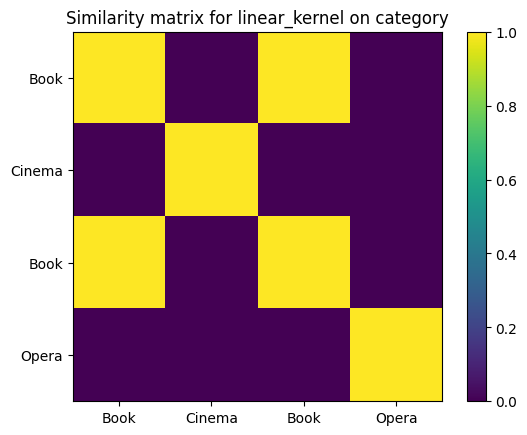

In [10]:
compute_sim_and_scores(user_categories, one_hot_encoder, 'category', linear_kernel)

Leverage scores [0.99322141 0.99322141 0.99948079 0.99322141 0.99869028 0.99809384]
Effective dimension 5.975929138732707

New item: One Piece T. 11 leverage=0.999

New item: One Piece T. 12 leverage=0.995
Max similarity to existing profile: 15.000

New item: Huis Clos de Sartre leverage=0.999
Max similarity to existing profile: 2.000

New item: One Piece T. 14 leverage=0.993
Max similarity to existing profile: 15.000

New item: One Piece: Film leverage=0.999
Max similarity to existing profile: 9.000

New item: One Piece OST leverage=0.998
Max similarity to existing profile: 11.000



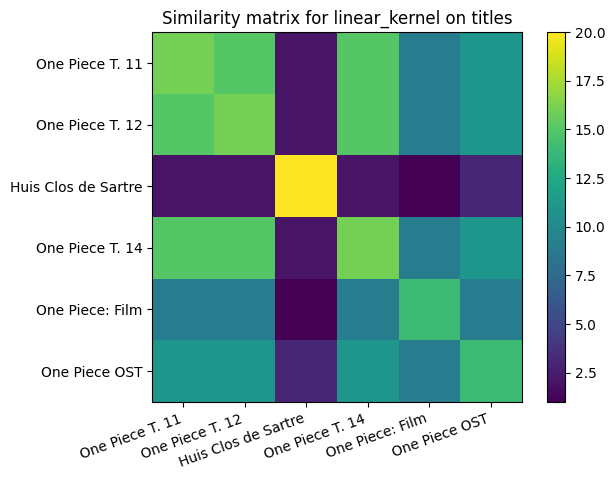

In [11]:
compute_sim_and_scores(user_titles, bigram_encoder, 'titles', linear_kernel)

Leverage scores [0.88493472 0.88493472 0.98685689 0.88493472 0.97329631 0.96205032]
Effective dimension 5.577007676546788

New item: One Piece T. 11 leverage=0.990

New item: One Piece T. 12 leverage=0.914
Max similarity to existing profile: 0.950

New item: Huis Clos de Sartre leverage=0.988
Max similarity to existing profile: 0.440

New item: One Piece T. 14 leverage=0.887
Max similarity to existing profile: 0.950

New item: One Piece: Film leverage=0.977
Max similarity to existing profile: 0.735

New item: One Piece OST leverage=0.962
Max similarity to existing profile: 0.815



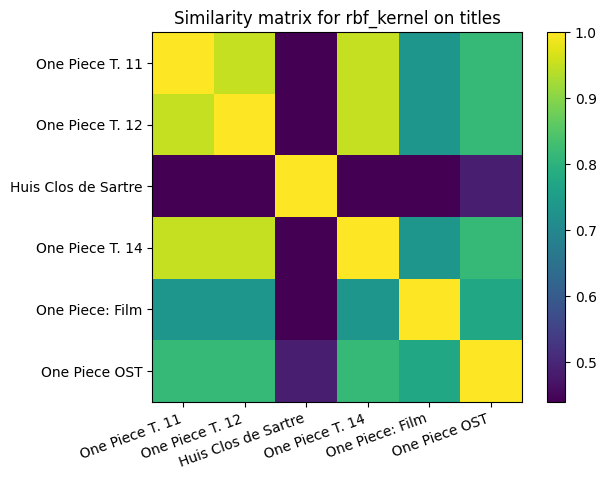

In [12]:
compute_sim_and_scores(user_titles, bigram_encoder, 'titles', rbf_kernel)